In [5]:
import pandas as pd

# Datei laden
file_path = "../data/processed/rental_data_room_canton_2023/Durchschnittlicher_Mietpreis_m2_Zimmerzahl_Kanton(2023).csv"
df_raw = pd.read_csv(file_path, encoding='ISO-8859-1', sep=';', skiprows=4)

# Nur die relevanten Spalten bis Zimmeranzahl 6 (inkl. Konfidenzintervalle)
df = df_raw.iloc[:, :14]

In [6]:
df.columns = ['Kanton', 'Total', 'CI_Total',
              '1_Zi', 'CI_1', '2_Zi', 'CI_2',
              '3_Zi', 'CI_3', '4_Zi', 'CI_4',
              '5_Zi', 'CI_5', '6_Zi']

In [7]:
# Relevante Spalten extrahieren
df_clean = df[['Kanton', '1_Zi', '2_Zi', '3_Zi', '4_Zi']].copy()

# Kommas durch Punkte ersetzen und evtl. Klammern entfernen
for col in ['1_Zi', '2_Zi', '3_Zi', '4_Zi']:
    df_clean[col] = df_clean[col].astype(str).str.replace(',', '.')
    df_clean[col] = df_clean[col].str.replace(r'\(|\)', '', regex=True)
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')  # NaN bei Fehler


In [8]:
# Wide-to-long Transformation
df_long = df_clean.melt(id_vars='Kanton', var_name='Zimmer', value_name='Preis_m2')
df_long['Zimmeranzahl'] = df_long['Zimmer'].str.extract(r'(\d)').astype(int)
df_long = df_long.drop(columns='Zimmer')

# Entferne Zeilen mit Text-Hinweisen oder fehlendem Preis
df_long = df_long[df_long['Preis_m2'].notna()]  # Nur Zeilen mit gültigem Preis
df_long = df_long[~df_long['Kanton'].str.contains(r'\*|\(|\)', na=False)]  # Entfernt Text mit * oder ( )


# Sortieren (optional)
df_long = df_long.sort_values(by=['Kanton', 'Zimmeranzahl'])

# Vorschau
df_long.head()


,Kanton,Preis_m2,Zimmeranzahl
19,Aargau,19.1,1
59,Aargau,18.7,2
99,Aargau,16.5,3
139,Aargau,15.4,4
15,Appenzell A.Rh.,13.7,1


KostenfunktionK(x), die die Gesamtkosten in Abhängigkeit von der Wohnfläche (x = Quadratmeter) beschreibt.

Schritt 1: Quadratmeter grob schätzen -> Wir brauchen eine Annahme für typische Flächen pro Zimmeranzahl.

Zimmeranzahl | Fläche (m²)

1 | 35

2 | 50

3 | 70

4 | 90

5 | 110

6 | 130

In [9]:
# Beispielhafte Flächenannahmen pro Zimmeranzahl
zimmer_flaeche = {
    1: 35,
    2: 50,
    3: 70,
    4: 90,
    5: 110,
    6: 130
}

# Neue Spalte mit geschätzter Wohnfläche
df_long['Wohnfläche_m2'] = df_long['Zimmeranzahl'].map(zimmer_flaeche)

Schritt 2: Kostenfunktion bauen

Die Gesamtkosten 𝐾 ( 𝑥 ) K(x) sind: K(x)=Preis_pro_m² × Wohnfläche

In [10]:
df_long['Gesamtkosten'] = df_long['Preis_m2'] * df_long['Wohnfläche_m2']

Schritt 3: Plotten pro Kanton (einfach zur Veranschaulichung)

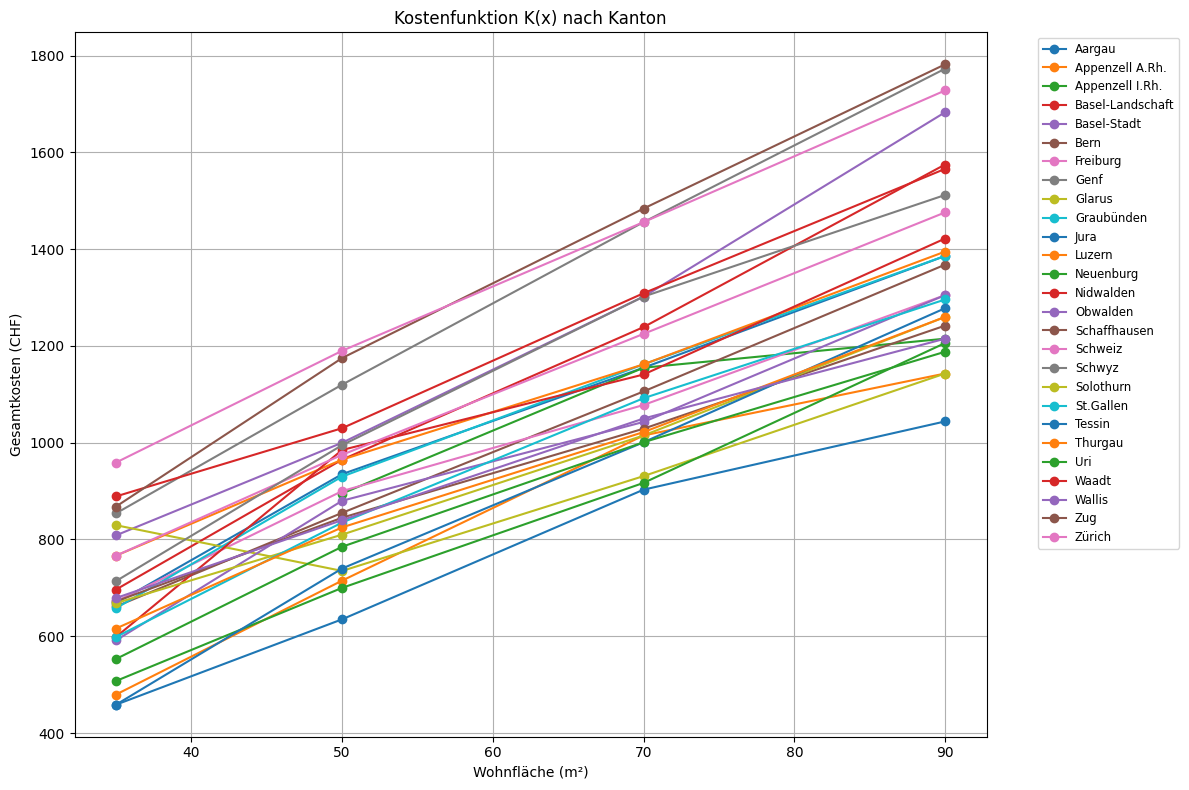

In [11]:
import matplotlib.pyplot as plt

# Alle Kantone in einem Plot
plt.figure(figsize=(12, 8))

for kanton, gruppe in df_long.groupby("Kanton"):
    plt.plot(gruppe['Wohnfläche_m2'], gruppe['Gesamtkosten'], marker='o', label=kanton)

plt.title("Kostenfunktion K(x) nach Kanton")
plt.xlabel("Wohnfläche (m²)")
plt.ylabel("Gesamtkosten (CHF)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


Ableitung der Kostenfunktion 𝐾 ′ ( 𝑥 ) K ′ (x) zur Bestimmung der Grenzkosten

Wie stark steigen die Gesamtkosten, wenn man einen zusätzlichen Quadratmeter Wohnfläche dazu nimmt?

1. Modellieren 𝐾 ( 𝑥 ) K(x) mit Regression (z. B. linear oder polynomial)
2. Ableitung 𝐾 ′ ( 𝑥 ) K ′ (x) berechnen (numerisch oder analytisch, je nach Modell)
3. Grenzkosten visualisieren

1. Modellieren der Kostenfunktion

In [17]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# Nimm z.B. den Durchschnitt aller Kantone
df_avg = df_long.groupby('Wohnfläche_m2').agg(Durchschnitt=('Gesamtkosten', 'mean')).reset_index()

# Daten vorbereiten
X = df_avg['Wohnfläche_m2'].values.reshape(-1, 1)
y = df_avg['Durchschnitt'].values

# Polynomial-Features 2. Ordnung
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Regression
model = LinearRegression()
model.fit(X_poly, y)

# Kostenfunktion modellieren
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)


Schritt 2: Numerische Ableitung 𝐾 ′ ( 𝑥 ) K ′ (x)


In [18]:
# Numerische Ableitung der geschätzten Kostenfunktion
from numpy import gradient

k_prime = gradient(y_pred, x_range.flatten())  # K'(x)


Schritt 3: Plot – Kostenfunktion & Grenzkostenfunktion

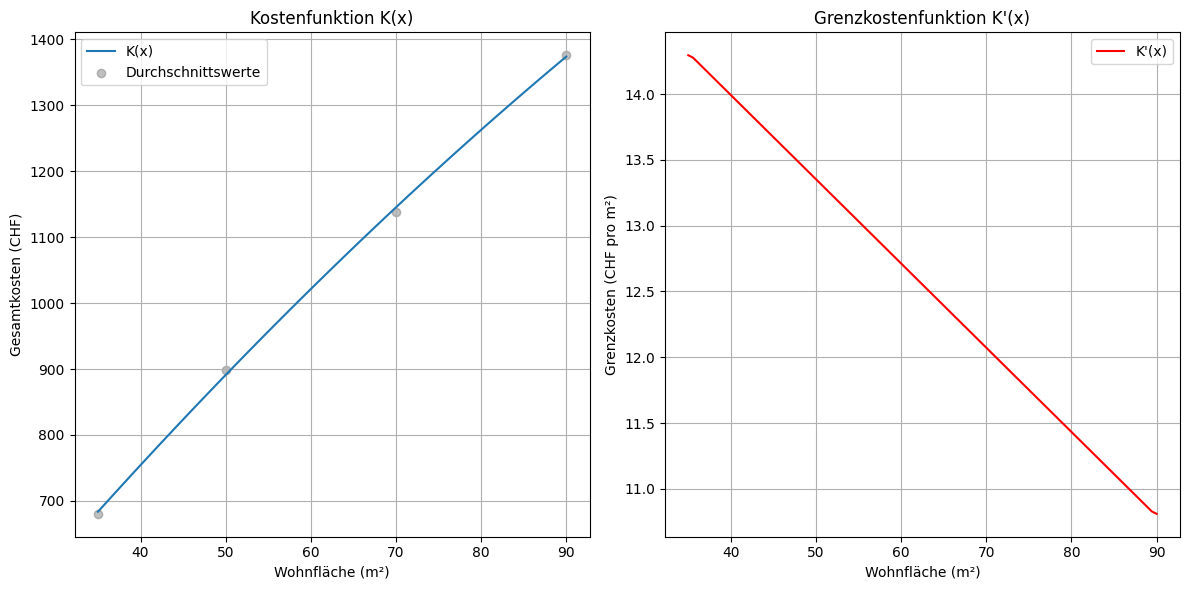

In [19]:
plt.figure(figsize=(12, 6))

# Plot der Kostenfunktion
plt.subplot(1, 2, 1)
plt.plot(x_range, y_pred, label='K(x)')
plt.scatter(X, y, color='gray', alpha=0.5, label='Durchschnittswerte')
plt.title("Kostenfunktion K(x)")
plt.xlabel("Wohnfläche (m²)")
plt.ylabel("Gesamtkosten (CHF)")
plt.grid(True)
plt.legend()

# Plot der Grenzkostenfunktion
plt.subplot(1, 2, 2)
plt.plot(x_range, k_prime, color='red', label="K'(x)")
plt.title("Grenzkostenfunktion K'(x)")
plt.xlabel("Wohnfläche (m²)")
plt.ylabel("Grenzkosten (CHF pro m²)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Grenzkosten pro Kanton

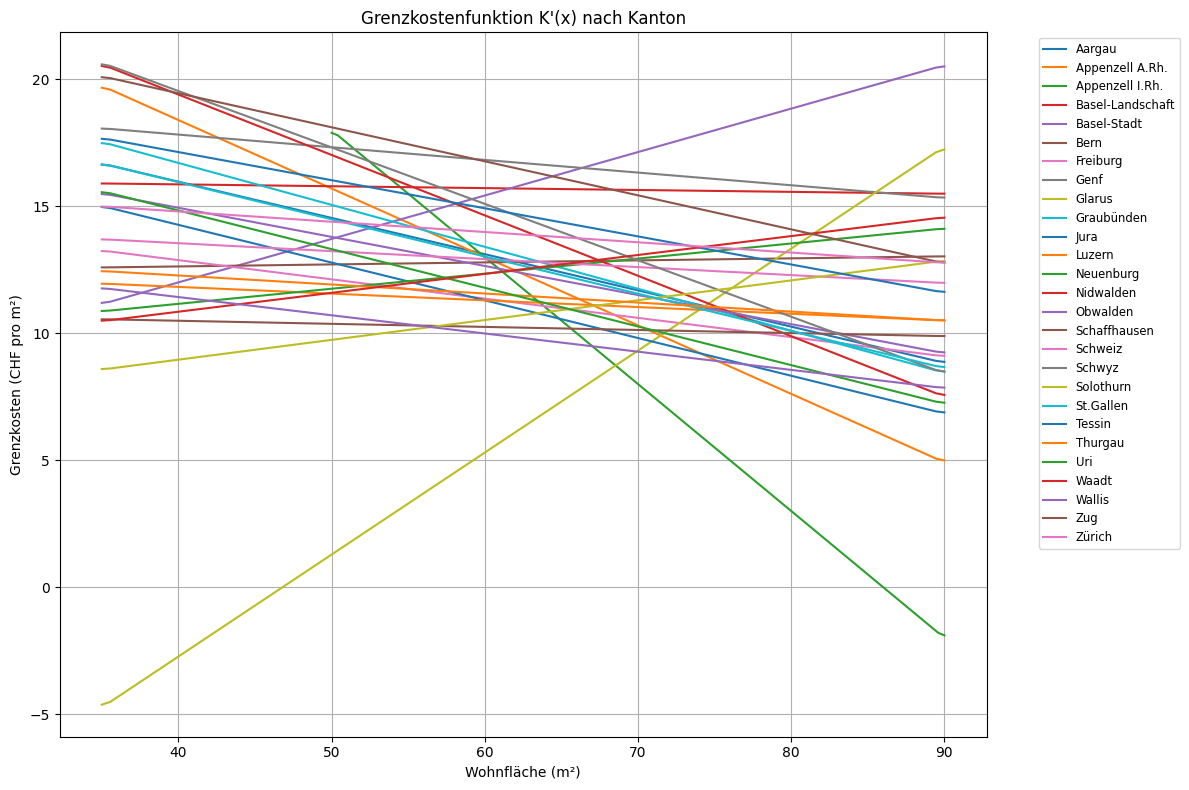

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Kanton-Grenzkosten vorbereiten
plt.figure(figsize=(12, 8))

# Kanton-Auswahl (optional begrenzen, z. B. nur Top 5 für Übersicht)
kantone = df_long['Kanton'].unique()  # Oder z. B. [:5] für schnelleren Test

for kanton in kantone:
    df_k = df_long[df_long['Kanton'] == kanton].dropna()

    # Sicherstellen, dass mindestens 3 Punkte da sind
    if len(df_k) < 3:
        continue

    X = df_k['Wohnfläche_m2'].values.reshape(-1, 1)
    y = df_k['Gesamtkosten'].values

    # Polynomial Regression (Grad 2)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)

    # Bereich für x-Werte (glatter Plot)
    x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred = model.predict(poly.transform(x_range))

    # Grenzkosten K'(x) via numerische Ableitung
    k_prime = np.gradient(y_pred, x_range.flatten())

    # Plot der Grenzkostenfunktion
    plt.plot(x_range, k_prime, label=kanton)

plt.title("Grenzkostenfunktion K'(x) nach Kanton")
plt.xlabel("Wohnfläche (m²)")
plt.ylabel("Grenzkosten (CHF pro m²)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()
